In [1]:
from pathlib import Path

from forecasting_models.lstm.model import LSTMForecastModel
import numpy as np
from data_utils.preprocessing import init_preprocess, resample_timeseries_dataframe
from data_utils.csv_utils import read_timeseries_csv


lstm_model = LSTMForecastModel(Path("__file__").parent / Path("examples/configs/lstm/lstm_config_example.yaml"))

2024-02-27 16:54:39.157555: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-27 16:54:39.159508: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 16:54:39.185002: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 16:54:39.185030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 16:54:39.185716: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

<Axes: xlabel='timestamp'>

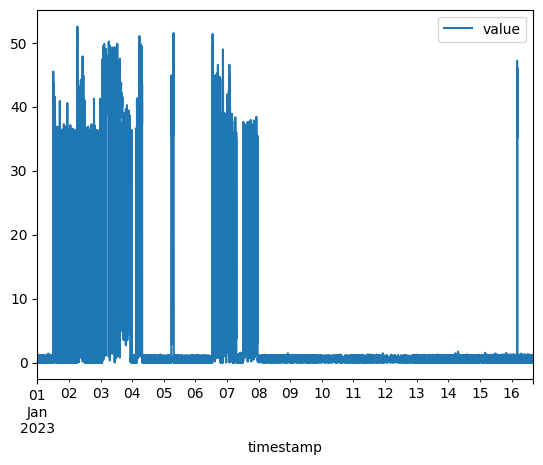

In [2]:
train_df = read_timeseries_csv(lstm_model.config.data_path)
train_df.plot()

<Axes: xlabel='timestamp'>

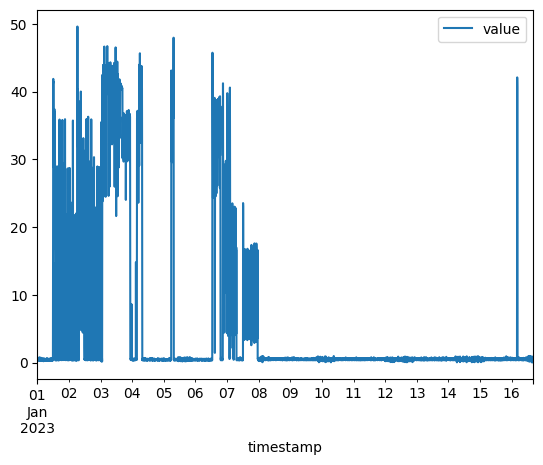

In [3]:
train_df = init_preprocess(
    train_df,
    base_step=lstm_model.config.preprocessing_parameters.initial_timedelta,
)
train_df = resample_timeseries_dataframe(
    train_df,
    step=lstm_model.config.preprocessing_parameters.target_timedelta,
)
train_df.plot()

In [4]:
import tensorflow as tf

tf.random.set_seed(50)
np.random.seed(50)


In [5]:
from tensorflow.keras.layers import LSTM

history = lstm_model.train(
    custom_inner_layers=[
        LSTM(32),
    ]
)

Epoch 1/50
99/99 [==============================] - 5s 20ms/step - loss: 0.0074 - mean_absolute_error: 0.0508 - val_loss: 6.1973e-04 - val_mean_absolute_error: 0.0181
Epoch 2/50
99/99 [==============================] - 1s 14ms/step - loss: 0.0050 - mean_absolute_error: 0.0355 - val_loss: 5.9408e-04 - val_mean_absolute_error: 0.0167
Epoch 3/50
99/99 [==============================] - 1s 13ms/step - loss: 0.0049 - mean_absolute_error: 0.0345 - val_loss: 5.1341e-04 - val_mean_absolute_error: 0.0137
Epoch 4/50
99/99 [==============================] - 1s 14ms/step - loss: 0.0048 - mean_absolute_error: 0.0347 - val_loss: 6.6523e-04 - val_mean_absolute_error: 0.0190
Epoch 5/50
99/99 [==============================] - 1s 15ms/step - loss: 0.0048 - mean_absolute_error: 0.0352 - val_loss: 4.9304e-04 - val_mean_absolute_error: 0.0135
Epoch 6/50
99/99 [==============================] - 1s 13ms/step - loss: 0.0047 - mean_absolute_error: 0.0336 - val_loss: 5.8191e-04 - val_mean_absolute_error: 0.017

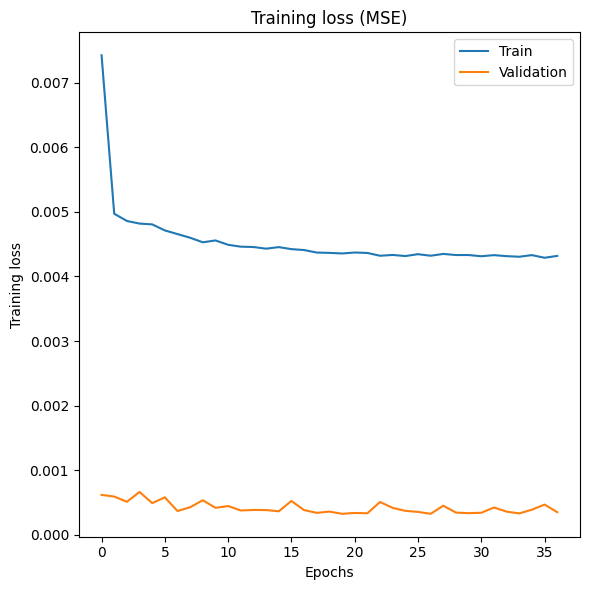

In [6]:
lstm_model.plotter.plot_training_loss(history)

<Axes: xlabel='timestamp'>

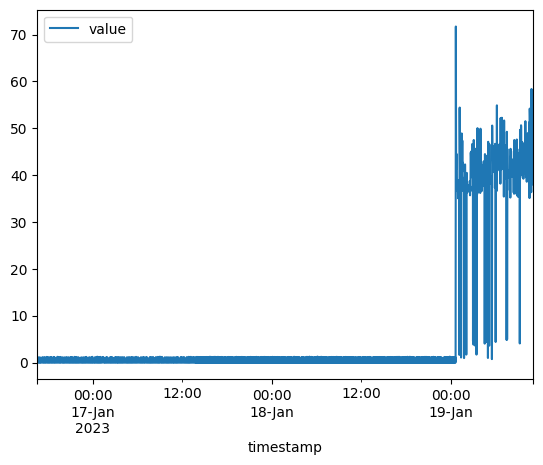

In [7]:
test_df = read_timeseries_csv(Path("./examples/sample_data/resource_usage_example_TEST.csv"))
test_df.plot()

<Axes: xlabel='timestamp'>

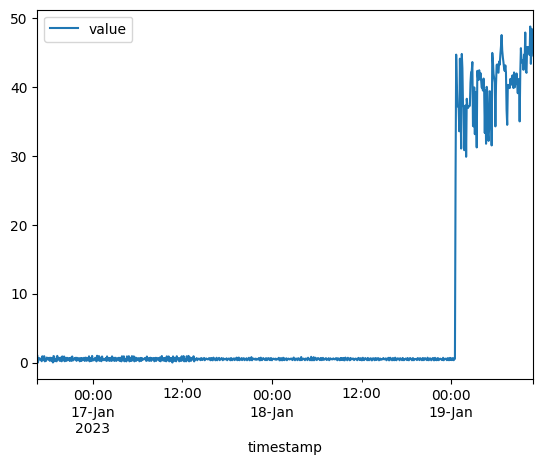

In [8]:
test_df_preprocessed = init_preprocess(
    test_df,
    base_step=lstm_model.config.preprocessing_parameters.initial_timedelta,
)
test_df_preprocessed = resample_timeseries_dataframe(
    test_df_preprocessed,
    step=lstm_model.config.preprocessing_parameters.target_timedelta,
)

test_df_preprocessed.plot()

In [9]:
init_inputs = train_df[-lstm_model.config.forecasting_parameters.input_width:]["value"]
print(init_inputs)

actuals, preds = lstm_model.test(
    test_df,
    init_inputs=init_inputs,
)

timestamp
2023-01-16 16:05:00    0.355722
2023-01-16 16:10:00    0.648733
2023-01-16 16:15:00    0.264214
2023-01-16 16:20:00    0.715619
2023-01-16 16:25:00    0.706766
2023-01-16 16:30:00    0.248290
Freq: 5T, Name: value, dtype: float64
1/1 [==============================] - 0s 19ms/step


<Axes: >

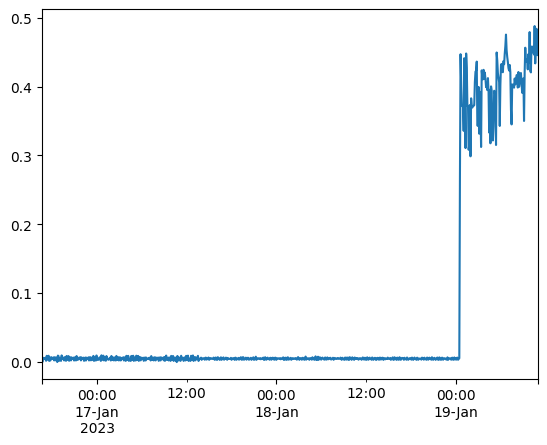

In [10]:
actuals.plot()

<Axes: >

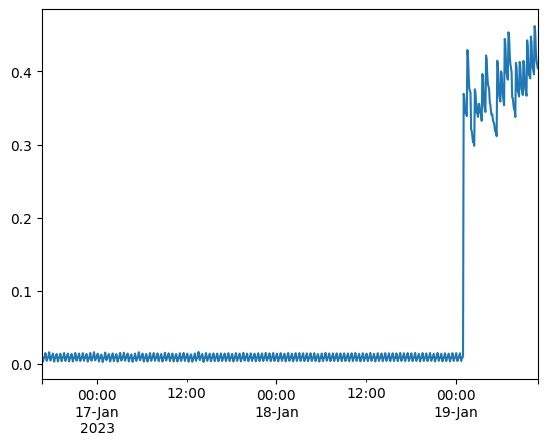

In [11]:
preds.plot()

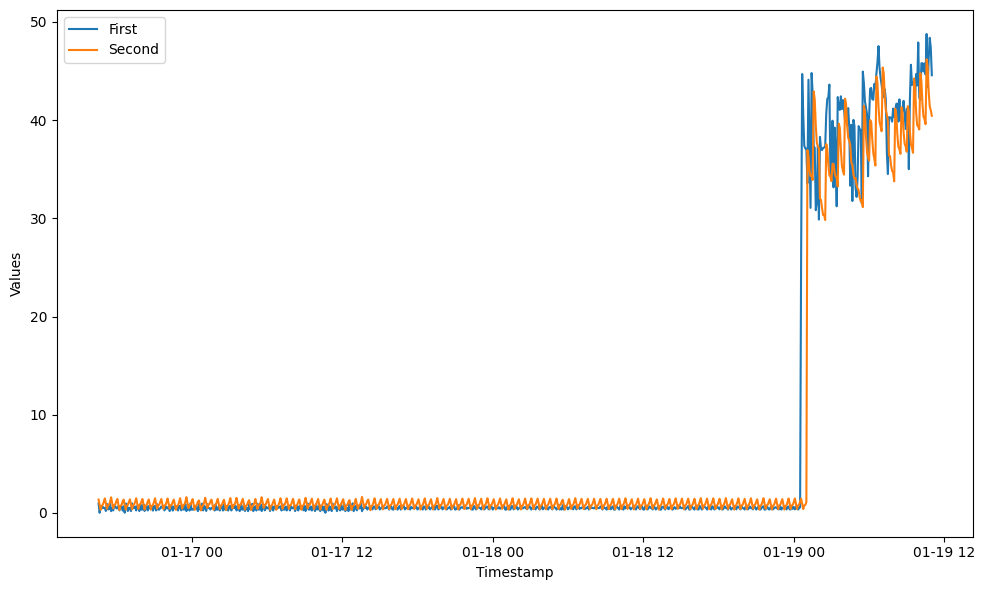

In [12]:
lstm_model.plotter.plot_two_series(actuals, preds)

In [13]:
anomaly_df = lstm_model.flag_anomalies(actuals, preds, 20)

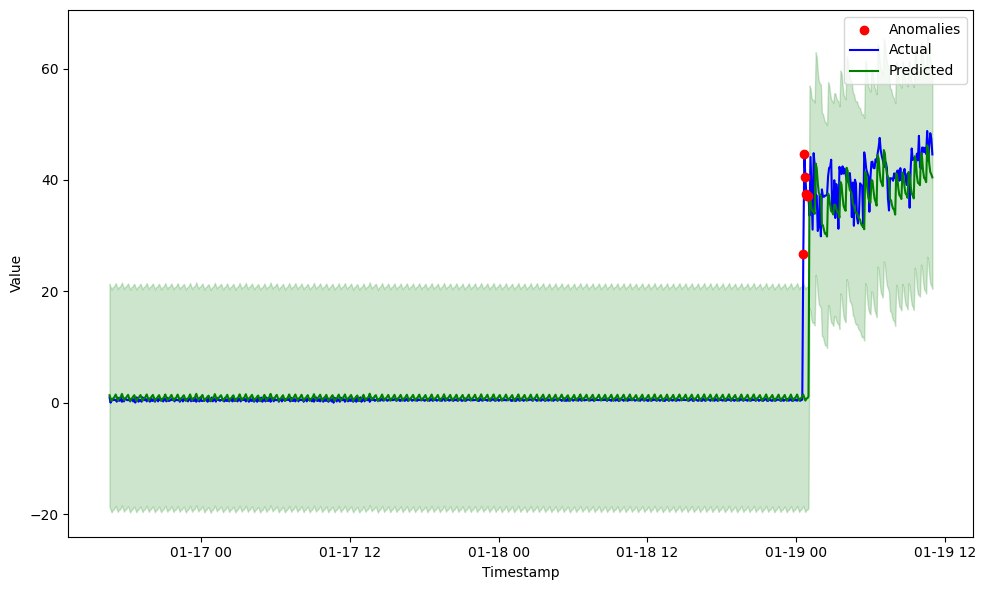

In [14]:
lstm_model.plotter.plot_anomalies(anomaly_df, 20)

<Axes: xlabel='timestamp'>

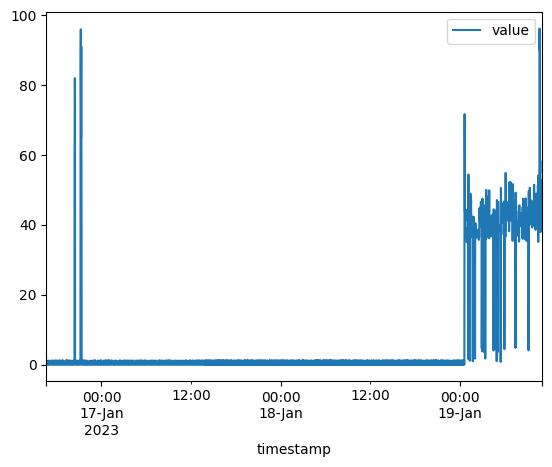

In [15]:
test_df_w_anomalies = read_timeseries_csv(Path("./examples/sample_data/resource_usage_example_ANOMALY_TEST.csv"))
test_df_w_anomalies.plot()

<Axes: xlabel='timestamp'>

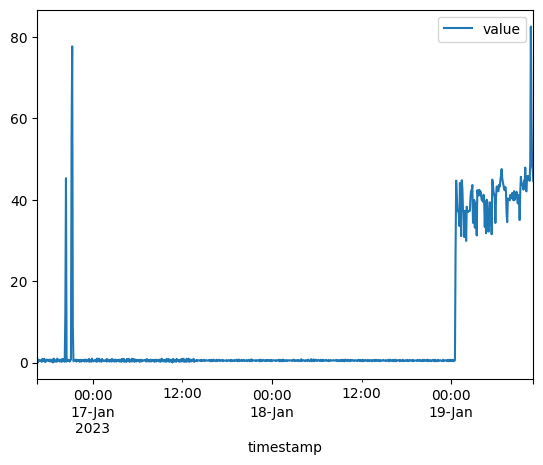

In [16]:
test_df_w_anomalies_preprocessed = init_preprocess(
    test_df_w_anomalies,
    base_step=lstm_model.config.preprocessing_parameters.initial_timedelta,
)
test_df_w_anomalies_preprocessed = resample_timeseries_dataframe(
    test_df_w_anomalies_preprocessed,
    step=lstm_model.config.preprocessing_parameters.target_timedelta,
)
test_df_w_anomalies_preprocessed.plot()

In [17]:
anomaly_actuals, anomaly_preds = lstm_model.test(test_df_w_anomalies, init_inputs)

1/1 [==============================] - 0s 20ms/step


In [18]:
new_anomaly_df = lstm_model.flag_anomalies(anomaly_actuals, anomaly_preds, 20)

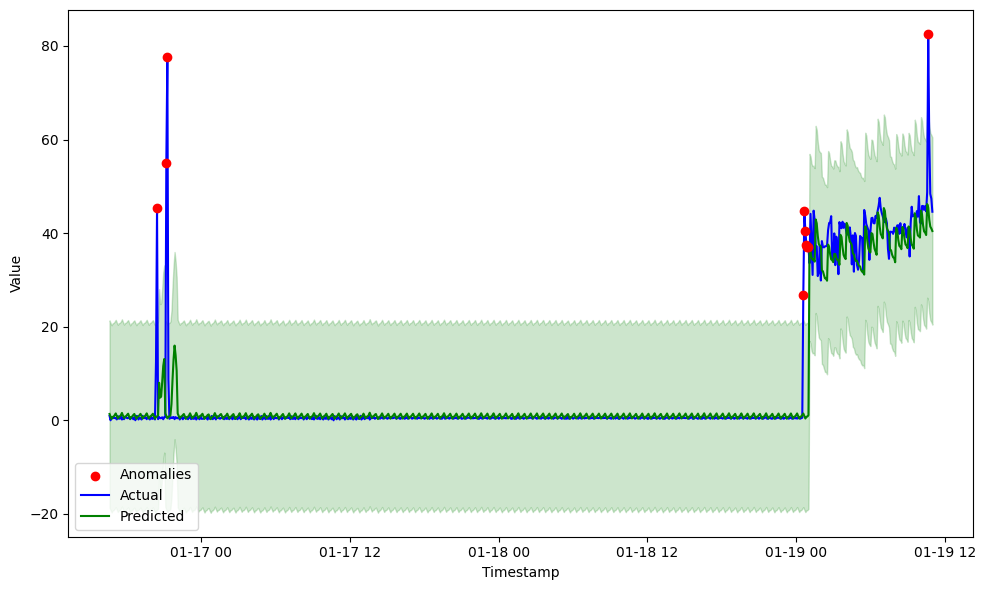

In [19]:
lstm_model.plotter.plot_anomalies(new_anomaly_df, 20)